# Model engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
import pickle


df = pd.read_csv('../data/processed/yield.csv')
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,avg_temp
0,Albania,Maize,1990,36613,1485.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,16.37


In [2]:
encoder = pickle.load(open('../artifacts/encoder.pkl', 'rb'))
encoded = pd.DataFrame(encoder.transform(
    df[['Item', 'Area']]), columns=encoder.get_feature_names_out())
df = df.drop(['Area', 'Item'], axis=1).join(encoded)
X = df.drop(['hg/ha_yield'], axis=1)
y = df['hg/ha_yield']

In [3]:
X.head()

,Year,average_rain_fall_mm_per_year,avg_temp,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,...,Area_Tajikistan,Area_Thailand,Area_Tunisia,Area_Turkey,Area_Uganda,Area_Ukraine,Area_United Kingdom,Area_Uruguay,Area_Zambia,Area_Zimbabwe
0,1990,1485.0,16.37,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1990,1485.0,16.37,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1990,1485.0,16.37,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1990,1485.0,16.37,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1990,1485.0,16.37,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
y.head()

0    36613
1    66667
2    23333
3    12500
4     7000
Name: hg/ha_yield, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape

(19200, 114)

In [6]:
def accuracy_score(actual, estimate):
    mae = mean_absolute_error(actual, estimate)
    mape = mean_absolute_percentage_error(actual, estimate)
    rmse = root_mean_squared_error(actual, estimate)
    r2 = r2_score(actual, estimate)
    print(f' MAE: {mae:.3f}\n MAPE: {mape:.3f}\n' +
          f' RMSE: {rmse:.3f}\n R2: {r2:.3f}')

## Baseline model

### Purpose

In [7]:
regressor = LogisticRegression(n_jobs=-1, max_iter=500)
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 6193.027
 MAPE: 0.153
 RMSE: 12778.986
 R2: 0.947


**Baseline model**: defined baseline accuracy for the predictor using `LogisticRegression` with default parameters.

---
## Model selection

In [8]:
forest = RandomForestRegressor(random_state=666, n_jobs=-1)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print('Score for RandomForestRegressor with default parameters')
accuracy_score(y_test, pred)

Score for RandomForestRegressor with default parameters
 MAE: 3188.799
 MAPE: 0.082
 RMSE: 7857.724
 R2: 0.980


In [9]:
estimators = [25, 50, 100, 200, 500, 1000]
for estimator in estimators:
    forest.set_params(n_estimators=estimator)
    score = cross_val_score(forest, X_train, y_train)
    print(f'CV-score for {estimator} estimators: {score.mean():.4f} and {score.std():.4f}')

CV-score for 25 estimators: 0.9775 and 0.0024
CV-score for 50 estimators: 0.9781 and 0.0021
CV-score for 100 estimators: 0.9782 and 0.0021
CV-score for 200 estimators: 0.9783 and 0.0021
CV-score for 500 estimators: 0.9785 and 0.0022
CV-score for 1000 estimators: 0.9785 and 0.0022


In [10]:
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 30809.616
 MAPE: 0.773
 RMSE: 49558.268
 R2: 0.210


In [11]:
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 40847.992
 MAPE: 1.224
 RMSE: 61109.633
 R2: -0.202


The model selected is **Random Forest** for its great applicability and higher efficiency in learning than SVM. Baseline `RandomForestRegressor` without any adjustment performs just better than `LogisticRegression` and is more efficient than `SVR` (in learning). Also `SVR` might have problems related to having many encoded categorical values.

---
## Hyperparameter Tuning

In [12]:
forest = RandomForestRegressor(n_jobs=-1, random_state=42)
param_grid = {
    'n_estimators': [25, 50, 100, 250, 500, 1000],
    'criterion': ['squared_error', 'friedman_mse', 'poisson'],
    'max_features': [None, 1, 'sqrt', 'log2']
}
grid = GridSearchCV(forest, param_grid, verbose=1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'criterion': 'squared_error', 'max_features': None, 'n_estimators': 1000}

Grid search gives us the best parameters for `RandomForestRegressor`:
- `n_estimators`: **1000**
- `max_features`: **None**
- `criterion`: **squared_error**

---
## Model evaulation

### Metrics

In [13]:
pred = grid.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 3136.433
 MAPE: 0.082
 RMSE: 7729.287
 R2: 0.981


### Cross fold validation

In [14]:
estimators = [25, 50, 100, 250, 500, 1000]
for estimator in estimators:
    forest.set_params(n_estimators=estimator)
    score = cross_val_score(forest, X_train, y_train, n_jobs=-1)
    print(f'CV-score for {estimator} estimators: {score.mean():.4f}')

CV-score for 25 estimators: 0.9775
CV-score for 50 estimators: 0.9780
CV-score for 100 estimators: 0.9784
CV-score for 250 estimators: 0.9784
CV-score for 500 estimators: 0.9785
CV-score for 1000 estimators: 0.9785


The model chosen is a `RandomForestRegressor`.  
- **Metrics**: with the parameters obtained from the previous optimization, the regressor gains only a slight increase in accuracy for much longer train time.
- **Cross validation**: performed cross validation with different number of estimators to see if it could help reduce the prediction error. A lower value could be used to limit resources usage as there is no significant increase in the CV-score.

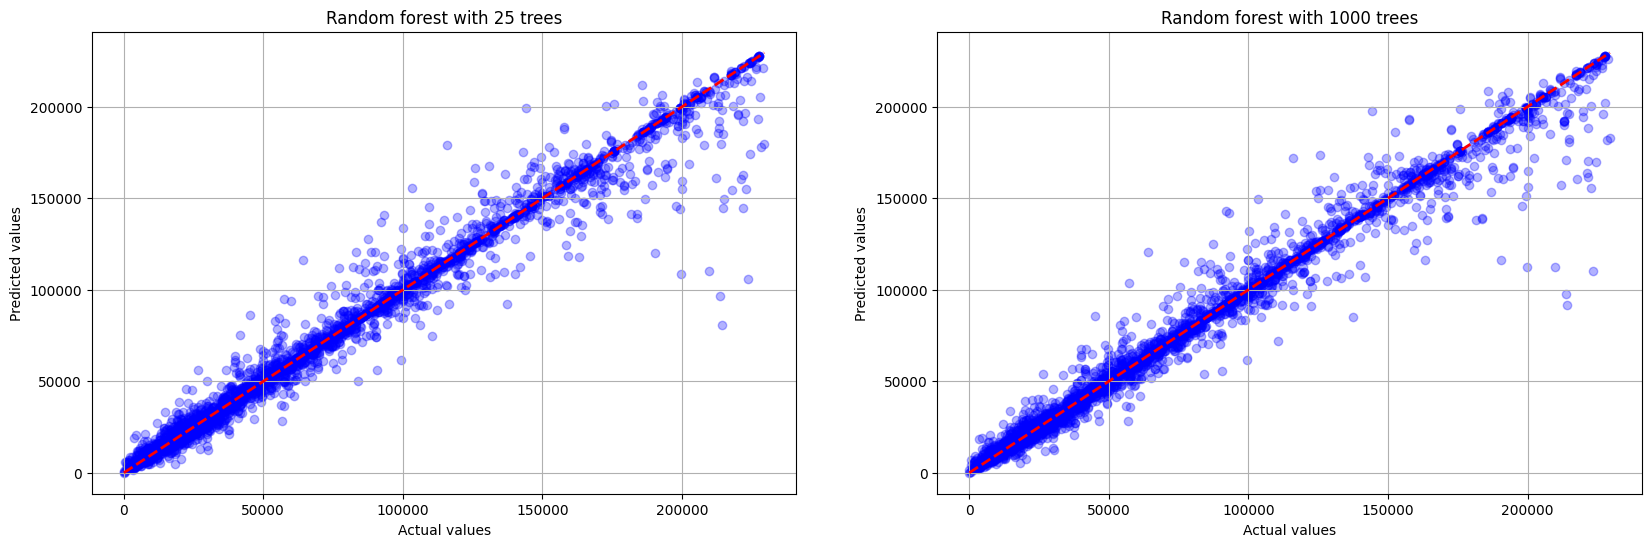

In [15]:
estimators = [25, 1000]
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for idx, n_estimators in enumerate(estimators):
    forest.set_params(n_estimators=n_estimators)
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    ax = axs[idx]
    ax.scatter(y_test, pred, color='blue', alpha=0.3)
    ax.plot([min(y_test), max(y_test)], [min(y_test),
                                         max(y_test)], color='red', lw='2', ls='--')
    ax.set_title(f'Random forest with {n_estimators} trees')
    ax.set_xlabel("Actual values")
    ax.set_ylabel('Predicted values')
    ax.grid(True)
plt.show()

- plotted predictions against actual values: the model correctly predicts data as expected from the previous results.
---

## Feature importance and model interpretability

In [16]:
important = forest.feature_importances_.argsort()[::-1]
X.columns[important]

Index(['Item_Potatoes', 'Item_Cassava', 'Item_Sweet potatoes', 'Item_Yams',
       'average_rain_fall_mm_per_year', 'avg_temp', 'Year',
       'Item_Plantains and others', 'Area_Mexico', 'Area_Japan',
       ...
       'Area_Niger', 'Area_Switzerland', 'Area_Tunisia', 'Area_Montenegro',
       'Area_Netherlands', 'Area_Estonia', 'Area_Austria', 'Area_Botswana',
       'Area_Latvia', 'Area_Germany'],
      dtype='object', length=114)

- **Feature importance**: from the model we can see above the most important features.
- Since the model has many rows due to the number of categories for the column `Area` (before encoding) Gini importance may not be accurate enough.

---

## Export the best model

In [17]:
file = open('../artifacts/model.pkl', 'wb')
pickle.dump(forest, file)
file.close()
file = open('../artifacts/encoder.pkl', 'wb')
pickle.dump(encoder, file)
file.close()
file = open('../artifacts/scaler.pkl', 'wb')
pickle.dump(scaler, file)
file.close()

- **Model**: exported to `artifacts/model.pkl`
- **Encoder**: exported to `artifacts/encoder.pkl`
- **Scaler**: exported to `artifacts/scaler.pkl`

---

## Conclusions

- **Baseline model**: defined a baseline model using `LogisticRegression` with default parameters.
- **Model Selection**: inspected other models (`RandomForestRegressor` and `SVR`). Chosen `RandomForestRegressor`
- **Hyperparameter tuning**: best parameters for the regressor:
  - ...
- **Model evaluation**: measured accuracy of the model with **default metrics** and **cross validation**.
- **Feature importance**: displayed feature importance for model interpretability.
- **Export**: exported the model along with the scaler and encoder.